# Modeling dataset bias in machine-learned theories of economic decision making - Analysis
This is the notebook needed to reproduce main plots and analysis from the paper.

Model predictions needed for most paper plots are already precomputed and stored in the csv files. The model notebook on the other hand shows how to work with the pretrained model files as well as train your own ones.

## Imports, data loading and initial setup

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, norm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import make_pipeline

In [3]:
cpc15_df = pd.read_csv("data/cpc15.csv", index_col=0)
choices_df = pd.read_csv("data/choices13k.csv", index_col=0)

In [4]:
base_features = ["Ha", "pHa", "La", "Hb", "pHb", "Lb", "LotNumB",
                 "LotShapeB", "Corr", "Amb", "Block", "Feedback"]
naive_features = ["diffEV", "diffSDs", "diffMins", "diffMaxs"]
psychological_features = ["diffUV", "RatioMin", "SignMax", "pBbet_Unbiased1",
                          "pBbet_UnbiasedFB", "pBbet_Uniform", "pBbet_Sign1",
                          "pBbet_SignFB", "Dom", "diffBEV0", "diffBEVfb", "diffSignEV"]
all_features = base_features + naive_features + psychological_features

In [5]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'font.size': 8})
params = {
    'legend.fontsize': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 8,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6
}
plt.rcParams.update(params)

### Utility functions

In [6]:
# Helper functions to calculate confidence intervals for pearson r and R^2 values
def pearsonr_ci(r, n, alpha):
    rp = np.arctanh(r)
    s = 1 / np.sqrt(n-3)
    ci = norm.ppf(1-(alpha/2)) * s
    l = rp - ci
    h = rp + ci
    return np.tanh(l), np.tanh(h)

def r_squared_ci(rsq, n, k, alpha):
    return norm.ppf(1-(alpha/2)) * np.sqrt((4*rsq*(1-rsq)**2*(n-k-1)**2)/((n**2-1)*(n+3)))

In [7]:
def fit_linreg(X, y):
    linreg = make_pipeline(MaxAbsScaler(), LinearRegression())
    linreg.fit(X, y)
    y_hat = linreg.predict(X)
    r_squared = pearsonr(y, y_hat)[0] ** 2
    mse = np.mean((y - y_hat) ** 2)
    baseline = np.mean((y - np.mean(y)) ** 2)
    return baseline, mse, r_squared

## Dataset difference
There are some obvious difference between CPC15 and choices13k, for example that CPC15 contains much more extreme behavior (all people deciding for one gamble).

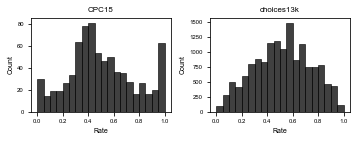

In [7]:
_, axes = plt.subplots(1, 2, figsize=(5,2))
sns.histplot(cpc15_df, x="Rate", color='k', bins=np.linspace(0,1,21), ax=axes[0])
axes[0].set_title("CPC15")
sns.histplot(choices_df, x="Rate", color='k', bins=np.linspace(0,1,21), ax=axes[1])
axes[1].set_title("choices13k")
plt.tight_layout()

## Relating features to NN difference 
First investigation which gamble or handcrafted (naive and psychological) feature can give us an insight into the difference in NN predictions.

This section reproduces Figure 2 and S3 and Table 2.

In [8]:
# color codes for the three feature categories
#fcolors = ["#ff7e33", "#9e023e", "#4751de"] # original
#fcolors = ["#44a5a5", "#f3d54f", "#e9603f"]
fcolors = ["#efd42e", "#e9603f", "#2eaeeb"] # best2
#fcolors = ["#b2a4ff", "#ffb4b4", "#ffdeb4"]
#fcolors = ["#ecee81", "#82a0d8", "#edb7ed"]
#fcolors = ["#ffb2a6", "#ff8aae", "#9adcff"] # best1

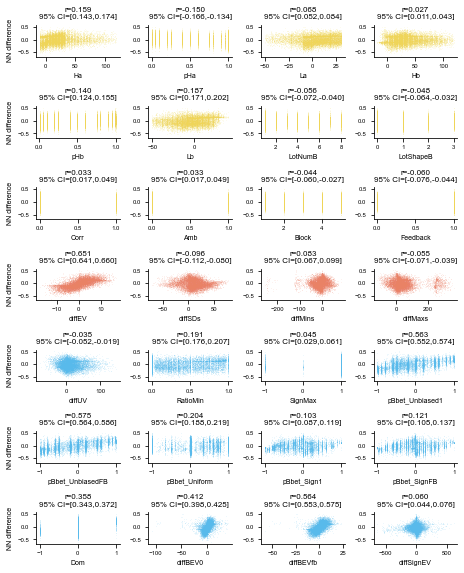

In [9]:
plt.figure(figsize=(6.5,8))
correlations = []
for i,f in enumerate(all_features):
    if i < 12:
        c = fcolors[0]
    elif i < 16:
        c = fcolors[1]
    else:
        c = fcolors[2]
    ax = plt.subplot(7, 4, i+1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    sns.scatterplot(x=choices_df[f], y=choices_df["nn_diff"], color=c, alpha=0.1, s=1, ax=ax, rasterized=True)
    if i%4 == 0:
        ax.set_ylabel("NN difference")
    else:
        ax.set_ylabel("")
    r = pearsonr(choices_df.nn_diff.values, choices_df[f].values)[0]
    rl, rh = pearsonr_ci(r, len(choices_df), 0.05)
    correlations.append(r)
    ax.set_title(f"r={r:.3f}\n95% CI=[{rl:.3f},{rh:.3f}]")
plt.tight_layout()

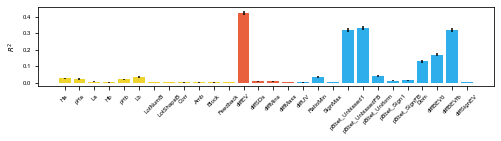

In [10]:
plt.figure(figsize=(7,2))
plt.bar(range(len(correlations)), np.array(correlations)**2,
        color=[fcolors[0]]*len(base_features)+[fcolors[1]]*len(naive_features)+
        [fcolors[2]]*len(psychological_features),
        yerr=[r_squared_ci(r**2, len(choices_df), 1, 0.05) for r in correlations])
plt.xticks(range(len(correlations)), all_features, rotation=45)
plt.ylabel(r"$R^2$")
plt.tight_layout()

In [11]:
for feature_set, name in zip(
    [base_features, base_features+naive_features, all_features, all_features+["SOSD", "TOSD"]],
    ["Base", "Base + Naive", "Base + Naive + Psych.", "Base + Naive + Psych. + HOSD"]
):
    baseline, mse, r_squared = fit_linreg(choices_df[feature_set], choices_df.nn_diff)
    print(f"Linear Regression between {name} and NN_difference")
    print(f"Baseline MSE: {baseline:.4f}, MSE: {mse:.4f}, R^2: {r_squared:.4f}")

Linear Regression between Base and NN_difference
Baseline MSE: 0.0249, MSE: 0.0220, R^2: 0.1186
Linear Regression between Base + Naive and NN_difference
Baseline MSE: 0.0249, MSE: 0.0126, R^2: 0.4932
Linear Regression between Base + Naive + Psych. and NN_difference
Baseline MSE: 0.0249, MSE: 0.0106, R^2: 0.5760
Linear Regression between Base + Naive + Psych. + HOSD and NN_difference
Baseline MSE: 0.0249, MSE: 0.0103, R^2: 0.5876


## Stochastic Dominance
Dominance was one of the higher correlated features with the difference in NN predictions, thus we took a closer look at the data with regard to stochastic dominance.

This section reproduces Figure 3.

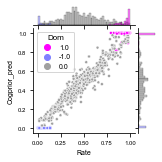

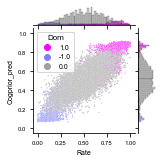

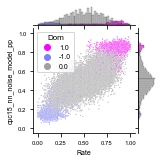

In [10]:
for i,(df, y, s) in enumerate(zip(
    [cpc15_df, choices_df, choices_df], ["Cogprior_pred", "Cogprior_pred", "cpc15_nn_noise_model_pp"], [35,5,5]
)):
    g = sns.JointGrid(
        data=df, x="Rate", y=y, hue="Dom", palette={-1: "#8080ff", 0: "#a0a0a0", 1: "#ff00ff"},
        height=2.3, hue_order=[1.0, -1.0, 0.0]
    )
    g.plot_joint(sns.scatterplot, marker=".", s=s, rasterized=True)
    g.plot_marginals(sns.histplot, bins=np.linspace(0, 1, 50))
    plt.savefig(f"tmp{i}.pdf", dpi=300)

## Feature Correlation
Some features are very similar to other ones or are containing the same information, thus we calculate the correlation matrix between them.

This section reproduces Figure S4.

In [12]:
feature_corr_matrix = np.zeros((len(all_features)+2,len(all_features)+2))
for i,f1 in enumerate(all_features+["SOSD", "TOSD"]):
    for j,f2 in enumerate(all_features+["SOSD", "TOSD"]):
        r = pearsonr(choices_df[f1], choices_df[f2])[0]
        feature_corr_matrix[i,j] = r

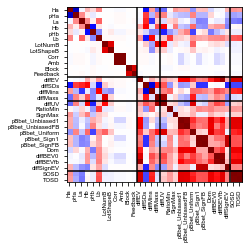

In [13]:
plt.figure(figsize=(3.5,3.5))
plt.imshow(feature_corr_matrix, vmin=-1, vmax=1, cmap="seismic")
plt.yticks(range(len(all_features)+2), all_features+["SOSD", "TOSD"])
plt.xticks(range(len(all_features)+2), all_features+["SOSD", "TOSD"], rotation=90)
for x in [11, 15, 27]:
    plt.axhline(x+.5, c="k")
    plt.axvline(x+.5, c="k")
plt.tight_layout()

## SHAP analysis
A common approach to investigate the behavior of NNs are XAI methods, like SHAP. They produce additive feature importance weights. We tried to investigate how these feature importance weights relate to the input features and to the known useful naive and psychological features.

The code to calculate the SHAP values for any two (Bourgin) Networks, is in the `shap_analysis.py` file in the `src` folder.

This section reproduces Figures 4 and S5.

In [66]:
diff_nn_shap_values = np.load("../../DecisionMaking/data/interim/diff_nn_shap_values_bourgin_choices_noprior.npy")

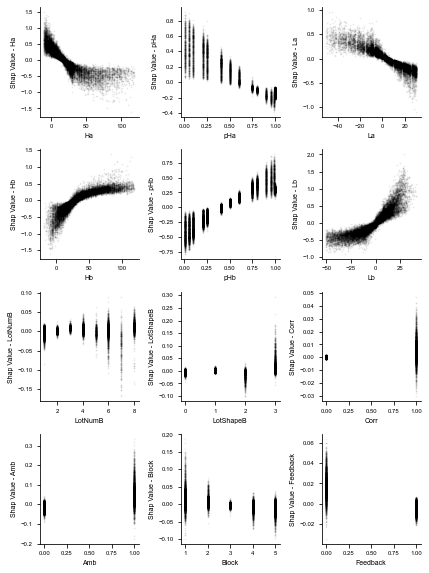

In [67]:
plt.figure(figsize=(6,8))
for i,f in enumerate(base_features):
    plt.subplot(4, 3, i+1)
    plt.scatter(choices_df[f], diff_nn_shap_values[:, i], s=1, alpha=0.05, c="k", zorder=-10)
    ax = plt.gca()
    ax.set_rasterization_zorder(-5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xlabel(f)
    plt.ylabel(f"Shap Value - {f}")
plt.tight_layout()

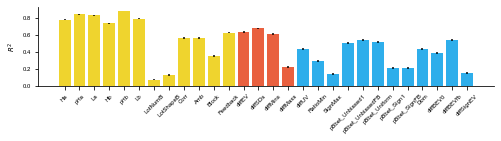

In [68]:
r_squareds = []
for f in all_features:
    lr = LinearRegression()
    y = choices_df[f].values
    lr.fit(diff_nn_shap_values, y)
    y_hat = lr.predict(diff_nn_shap_values)
    r_squareds.append(pearsonr(y, y_hat)[0] ** 2)
plt.figure(figsize=(7,2))
plt.bar(range(len(r_squareds)), r_squareds,
        color=[fcolors[0]]*len(base_features)+[fcolors[1]]*len(naive_features)+
        [fcolors[2]]*len(psychological_features),
        yerr=[r_squared_ci(rsq, len(choices_df), 12, 0.05) for rsq in r_squareds])
plt.xticks(range(len(r_squareds)), all_features, rotation=45)
plt.ylabel(r"$R^2$")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()